<a href="https://colab.research.google.com/github/kamalmalikofficial/AIMS-softwarework/blob/main/finetuning_of_fasterrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
from pathlib import Path
import shutil

json_path = Path("/content/result.json")

# Backup original file
backup_path = json_path.with_suffix(".backup.json")
shutil.copy(json_path, backup_path)
print(f"Backup created at: {backup_path}")

# Load JSON
with open(json_path, "r") as f:
    data = json.load(f)

# Clean up file_name entries
for img in data.get("images", []):
    if "file_name" in img:
        # Normalize slashes and keep only filename
        img["file_name"] = Path(img["file_name"].replace("\\", "/")).name

# Save back
with open(json_path, "w") as f:
    json.dump(data, f, indent=2)

print("file_name fields updated successfully!")



Backup created at: /content/result.backup.json
file_name fields updated successfully!


In [ ]:
import json

json_path = "/content/result.json"
with open(json_path) as f:
    data = json.load(f)

category_ids = [cat["id"] for cat in data["categories"]]
print("Category IDs:", category_ids)


Category IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [ ]:
from pycocotools.coco import COCO
coco = COCO(json_path)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 120MB/s]


Epoch 1, Avg Loss: 1.2206
Epoch 2, Avg Loss: 0.9507
Epoch 3, Avg Loss: 0.8672
Epoch 4, Avg Loss: 0.8025
Epoch 5, Avg Loss: 0.7122
Epoch 6, Avg Loss: 0.6696
Epoch 7, Avg Loss: 0.5926
Epoch 8, Avg Loss: 0.5602
Epoch 9, Avg Loss: 0.5174
Epoch 10, Avg Loss: 0.4590
Epoch 11, Avg Loss: 0.4285
Epoch 12, Avg Loss: 0.4000
Epoch 13, Avg Loss: 0.3663
Epoch 14, Avg Loss: 0.3407
Epoch 15, Avg Loss: 0.3337
Training done, model saved!


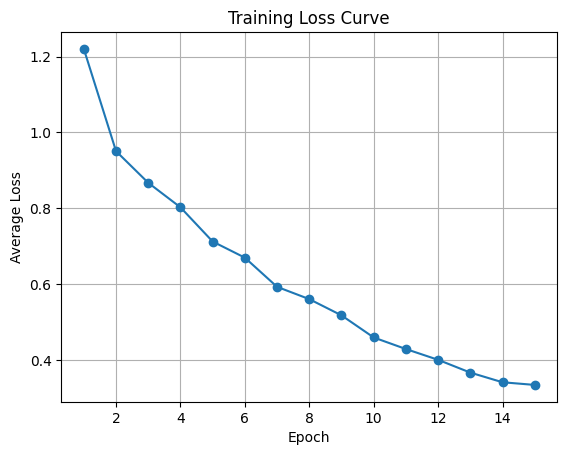

In [ ]:
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
images_root = "/content/drive/MyDrive/images"
annotations_file = "/content/result.json"
num_classes = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.Compose([T.ToTensor()])
dataset = CocoDetection(root=images_root, annFile=annotations_file, transform=transform)

# Collate function
def collate_fn(batch):
    imgs, anns = zip(*batch)
    targets = []
    for i, ann in enumerate(anns):
        boxes = []
        labels = []
        if ann:
            for obj in ann:
                bbox = obj["bbox"]
                x_min, y_min, w, h = bbox
                img_width, img_height = imgs[i].size(2), imgs[i].size(1)

                x_max = x_min + w
                y_max = y_min + h
                x_min = max(0., float(x_min))
                y_min = max(0., float(y_min))
                x_max = min(float(img_width), float(x_max))
                y_max = min(float(img_height), float(y_max))

                if x_max > x_min and y_max > y_min:
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(obj["category_id"])

            if boxes:
                targets.append({
                    "boxes": torch.tensor(boxes, dtype=torch.float32),
                    "labels": torch.tensor(labels, dtype=torch.int64),
                })
            else:
                targets.append({"boxes": torch.empty((0, 4)), "labels": torch.empty((0,), dtype=torch.int64)})
        else:
            targets.append({"boxes": torch.empty((0, 4)), "labels": torch.empty((0,), dtype=torch.int64)})

    return imgs, targets

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# -------------------------
# Track training
# -------------------------
num_epochs = 15
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, targets in data_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(data_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

    # Save weights after each epoch
    torch.save(model.state_dict(), f"fasterrcnn_epoch_{epoch+1}.pth")

# -------------------------
# Save final model
# -------------------------
torch.save(model.state_dict(), "fasterrcnn_custom.pth")
print("Training done, model saved!")

# -------------------------
# Save loss data
# -------------------------
with open("loss_history.txt", "w") as f:
    for i, loss in enumerate(loss_history, 1):
        f.write(f"Epoch {i}: {loss:.4f}\n")

# -------------------------
# Plot loss graph
# -------------------------
plt.figure()
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()
